Using existing label encoder with classes: ['angry' 'fear' 'happy' 'neutral' 'sad' 'surprise']
[INFO] Loading images and extracting landmarks...
[INFO] Loaded 26154 samples.
[INFO] Balancing dataset with SMOTE...
[INFO] Training MLP model...
Iteration 1, loss = 1.47233805
Iteration 2, loss = 1.34104868
Iteration 3, loss = 1.31157410
Iteration 4, loss = 1.28674495
Iteration 5, loss = 1.26615389
Iteration 6, loss = 1.25609769
Iteration 7, loss = 1.24908340
Iteration 8, loss = 1.23746397
Iteration 9, loss = 1.25048419
Iteration 10, loss = 1.22790389
Iteration 11, loss = 1.20395792
Iteration 12, loss = 1.19592242
Iteration 13, loss = 1.18434031
Iteration 14, loss = 1.19097944
Iteration 15, loss = 1.20964460
Iteration 16, loss = 1.16808394
Iteration 17, loss = 1.15707441
Iteration 18, loss = 1.14550155
Iteration 19, loss = 1.14578078
Iteration 20, loss = 1.14063499
Iteration 21, loss = 1.13997149
Iteration 22, loss = 1.13074085
Iteration 23, loss = 1.12092134
Iteration 24, loss = 1.11424429

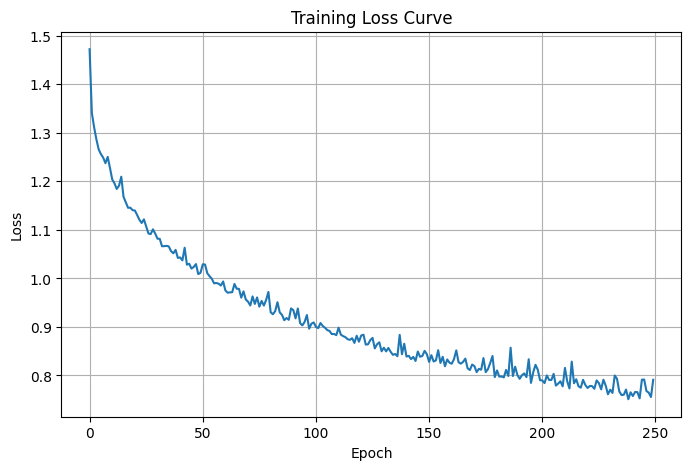

[INFO] Evaluating model...
              precision    recall  f1-score   support

       angry       0.57      0.63      0.59      1417
        fear       0.57      0.46      0.51      1420
       happy       0.74      0.78      0.76      1365
     neutral       0.54      0.54      0.54      1342
         sad       0.47      0.49      0.48      1408
    surprise       0.81      0.81      0.81      1350

    accuracy                           0.62      8302
   macro avg       0.62      0.62      0.62      8302
weighted avg       0.62      0.62      0.61      8302



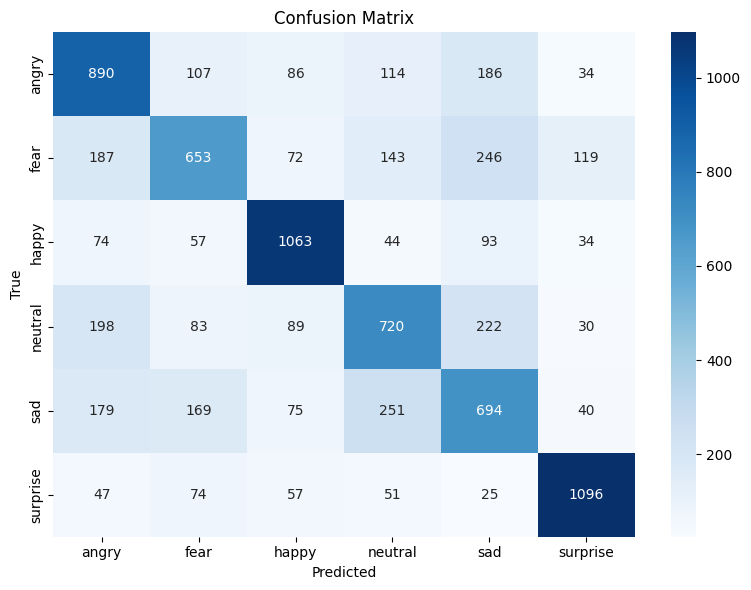

[INFO] MLP model and scaler saved.


In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load existing label encoder
le = joblib.load("label_encoder2.pkl")
print("Using existing label encoder with classes:", le.classes_)

# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Prepare data
X = []
y = []

# Dataset directory
data_dir = 'train'

print("[INFO] Loading images and extracting landmarks...")
for label in os.listdir(data_dir):
    if label.lower() == 'disgust':  # Skip 'disgust' class
        continue
    label_folder = os.path.join(data_dir, label)
    if not os.path.isdir(label_folder):
        continue
    for img_file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            coords = []
            for lm in landmarks.landmark:
                coords.extend([lm.x, lm.y])
            X.append(coords)
            y.append(label)

print(f"[INFO] Loaded {len(X)} samples.")

# Convert to arrays
X = np.array(X)
y = np.array(y)

# Transform labels using existing encoder
y_encoded = le.transform(y)

# Balance dataset using SMOTE
print("[INFO] Balancing dataset with SMOTE...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_encoded)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)

# Train MLP model
print("[INFO] Training MLP model...")
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, verbose=True)
mlp.fit(X_train, y_train)
print("[INFO] Training complete!")

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluate
print("[INFO] Evaluating model...")
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Save model and scaler (not the encoder)
joblib.dump(mlp, "mlp_emotion_model_balanced.pkl")
joblib.dump(scaler, "scaler.pkl")
print("[INFO] MLP model and scaler saved.")
